In [1]:
import pandas
import numpy
import timeit

from limit_order_book import (
    LimitOrder,
    Direction,
    ArrayDequeLimitOrderBook,
    HashDequeLimitOrderBook,
    BalancedTreeDequeLimitOrderBook,
    load_msft_orders,
)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Context

We benchmark different limit order book implementations using a sample limit orders. We do not consider order amendments or cancellations in this study.

### Load test data

In [2]:
df_orders = (
    load_msft_orders()
    # We only consider new limit orders
    .loc[lambda x: x["Type"].isin([1])]
    .assign(
        Direction=lambda x: x["Direction"].map(
            {
                -1: Direction.Sell,
                1: Direction.Buy
            }
        )
    )
)

In [3]:
df_orders.head()

,Time,Type,OrderID,Size,Price,Direction
1,34200.013994,1,16116348,100,310500,Direction.Sell
2,34200.015248,1,16116658,100,310400,Direction.Sell
3,34200.015442,1,16116704,100,310500,Direction.Sell
4,34200.015789,1,16116752,100,310600,Direction.Sell
5,34200.016300,1,16116815,100,310700,Direction.Sell


In [4]:
orders = [
    LimitOrder(
        id=order["OrderID"],
        trader_id=1,
        direction=order["Direction"],
        quantity=order["Size"],
        price=order["Price"],
    )
    for _, order in df_orders.iterrows()
]

In [5]:
max_price = df_orders["Price"].max() + 1

In [6]:
n_orders = len(df_orders)

In [7]:
n_orders

69946

### Benchmark

We will benchmark adding the 69946 orders to the order book.

In [8]:
def benchmark(limit_order_book, orders):
    """Method to benchmark"""
    for order in orders:
        limit_order_book.add(order)

In [9]:
lobs = {
    "ArrayDeque": ArrayDequeLimitOrderBook,
    "HashDeque": HashDequeLimitOrderBook,
    "BalancedTreeDeque": BalancedTreeDequeLimitOrderBook,
}

out = {}

n_loops = 64

for name, lob in lobs.items():

    # Instantiate LOB
    l = lob(name="MSFT", max_price=max_price)

    # Time benchmark method
    for _ in range(n_loops):
        out.setdefault(name, []).append(
            timeit.timeit('benchmark(l, orders)', globals=globals(), number=1)
        )

df_benchmark = pandas.DataFrame(out)

In [10]:
# Divide by number of orders, express in micro seconds
df_per_order_micro = (df_benchmark / n_orders) * 1e6

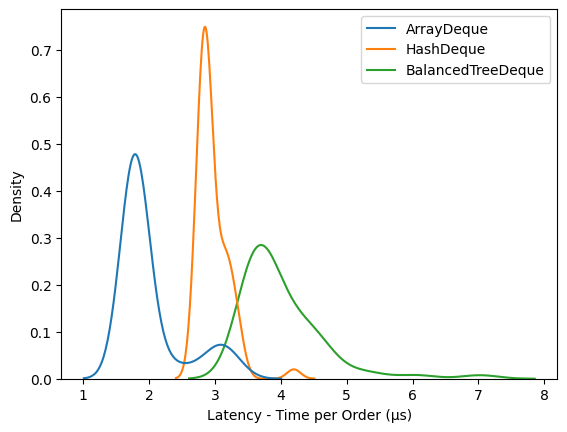

In [11]:
f = sns.kdeplot(df_per_order_micro)

f.set_xlabel("Latency - Time per Order (µs)");

In [12]:
df_per_order_micro.describe()

,ArrayDeque,HashDeque,BalancedTreeDeque
count,64.000000,64.000000,64.000000
mean,2.011661,2.965061,4.015956
std,0.481323,0.239310,0.638616
min,1.637116,2.719259,3.440952
25%,1.744525,2.831596,3.574672
50%,1.814236,2.885749,3.796478
75%,1.917887,3.105022,4.236837
max,3.376220,4.197317,7.021685
